# 溯源树衍生：论文图的制作
几个方向：  
1. 溯源树-森林版
2. 基于已有论文的桑基图
3. 加入论文质量、有用程度检测

In [1]:
import os
from dotenv import load_dotenv

# 加载 .env 文件
load_dotenv()

# 尝试获取环境变量并打印出来
dashscope_api_key = os.getenv("DASHSCOPE_API_KEY")

## 1.解析+LLM评估论文质量
两种评估类型：  
1. 非量化，仅对低质量论文进行过滤：可以在进行论文解析时一并进行，增加一个布尔值的key：has_value，直接基于摘要进行判断；  
2. 如果需要更精细、量化的评价，则应该在解析之外，单独对LLM进行一次调用

In [2]:
from langchain_community.llms import Tongyi
from langchain.prompts import PromptTemplate

In [13]:
# 论文信息提取
class ParseLLM:
    def __init__(self,model_name,api_key):
        self.llm=Tongyi(model=model_name,api_key=api_key)
        
        # 解析论文信息，包括 标题、发表日期和摘要
        self.parse_prompt_template=PromptTemplate(template="""
            <document>{document}</document>
            
            <instruction>
                Extract the following information from the document above and return it in JSON format:
                - Title of the paper
                - publication date, use'%Y-%m-%d' fromat
                - Abstract
            </instruction>
                
            <output_example>
                Output example:
                {{
                    "title": "The title of the paper",
                    "publication_date": "2025-03-13",
                    "abstract": "The abstract of the paper"
                }}
            </output_example>
            """)
        
        
    
    def response(self,prompt):
        response=self.llm.invoke(prompt)
        return response
    
    def parse_paper(self,paper):
        prompt=self.parse_prompt_template.format(document=paper)
        response=self.response(prompt)
        return response

In [14]:
class JudgeLLM:
    def __init__(self,model_name,api_key):
        self.llm=Tongyi(model=model_name,api_key=api_key)
        
        # 解析论文信息，包括 标题、发表日期和摘要
        self.judge_prompt_template=PromptTemplate(template="""
            <document>{document}</document>
            
            <instruction>
            Please evaluate the paper's contribution based on the following criteria, scoring each dimension from 1-5. Calculate the final average score (rounded to one decimal place):

            【Evaluation Dimensions & Scoring Rubrics】
            1. Innovation (Theoretical/Methodological Breakthrough)
            - 5: Establishes a new research direction (e.g., Transformer)
            - 4: Significant improvement or novel application scenario
            - 3: Incremental improvement over existing methods
            - 2: Minor tweaks or reproducibility study
            - 1: Lacking substantive innovation

            2. Impact (Academic Contribution)
            - 5: Revolutionizes the research paradigm
            - 4: Frequently cited by influential papers
            - 3: Moderate citations (10-50/year)
            - 2: Limited citations (<10/year)
            - 1: No academic influence

            3. Methodological Rigor
            - 5: Complete theoretical proof & robust experiments
            - 4: Reliable method with minor limitations
            - 3: Basic validity but lacks thorough validation
            - 2: Invalid key assumptions
            - 1: Fundamental methodological flaws

            4. Practical Value
            - 5: Demonstrated industrial applications
            - 4: Clear potential for real-world use
            - 3: Requires major modifications for application
            - 2: Extremely limited use cases
            - 1: No practical utility

            5. Completeness (Reproducibility)
            - 5: Open-sourced code/data with full replication
            - 4: Partial implementation details provided
            - 3: Ambiguous key implementations
            - 2: Lacking critical experimental details
            - 1: Intentional withholding of core methods

            Output format:
            [Dimension 1]: X (brief justification)
            [Dimension 2]: X (brief justification)
            ...
            Final Score: X.X
            </instruction>
               
            """)
        
        
    
    def response(self,prompt):
        response=self.llm.invoke(prompt)
        return response
    
    def judge_paper(self,paper)->str:
        prompt=self.judge_prompt_template.format(document=paper)
        response=self.response(prompt)
        return response

In [25]:
judge_llm = JudgeLLM(model_name="qwen-turbo", api_key=dashscope_api_key)

from PyPDF2 import PdfReader
paper_path="../data/You Know What I'm Saying Jailbreak Attack via Implicit Reference.pdf"

reader = PdfReader(paper_path)
paper_content = ""

# 遍历每一页并提取文本
for page in reader.pages:
    paper_content += page.extract_text()
    
score_output=judge_llm.judge_paper(paper_content)
print(score_output)

[Innovation (Theoretical/Methodological Breakthrough)]: 4  
Justification: The paper introduces a novel jailbreak method called Attack via Implicit Reference (AIR), which effectively bypasses existing detection mechanisms by decomposing malicious objectives into nested harmless objectives and leveraging implicit references. While it represents a significant advancement in jailbreak techniques, it builds upon existing adversarial attack strategies and does not fundamentally redefine the field.

[Impact (Academic Contribution)]: 3  
Justification: The AIR method has the potential to be frequently cited due to its novelty and effectiveness in bypassing current LLM security measures. However, its immediate revolution of the research paradigm is limited, and it may take some time for it to gain moderate citations (10-50/year).

[Methodological Rigor]: 4  
Justification: The paper provides a comprehensive framework for AIR, including theoretical explanations, experimental setups, and cross-m

In [26]:
print(type(score_output))

<class 'str'>


In [28]:
match = re.search(r'Final Score:\s*(\d+(\.\d+)?)', score_output)
if match:
    final_score = float(match.group(1))  # 提取分数并转换为浮点数
    print(f"Extracted Final Score: {final_score}")
else:
    print("Final Score not found.")

Extracted Final Score: 3.6


In [37]:
# 论文分类
class ClassifyLLM:
    def __init__(self,model_name,api_key):
        self.llm=Tongyi(model=model_name,api_key=api_key)
        # 
        self.classify_prompt_template = PromptTemplate(template="""
            <abstract>{abstract}</abstract>
            <instruction>
            Given the abstract of a scientific paper, please classify it into one of the following categories:

            category: base on abstract of the paper, choose one category that best describes the paper's focus:
            - adversarial_attack : Techniques designed to deceive machine learning models by introducing small perturbations to inputs, causing incorrect predictions or outputs.
            - adversarial_defense : Methods aimed at improving the robustness of machine learning models against adversarial attacks, ensuring reliable performance under malicious inputs.
            - jailbreak_attack : Strategies to bypass the ethical, safety, or content restrictions imposed on language models, enabling unintended or harmful behaviors.
            - jailbreak_defense : Approaches to prevent or mitigate jailbreak attacks, ensuring language models adhere to their intended safety and ethical guidelines.
            - prompt_injection_attack : Exploiting vulnerabilities in language models by crafting malicious prompts to manipulate model outputs for unintended purposes.
            - promp_injection_defense : Techniques to detect and prevent prompt injection attacks, safeguarding models from maliciously crafted inputs.
            - backdoor_attack : Injecting hidden triggers into machine learning models during training, which cause the model to produce specific, often malicious outputs when activated.
            - backdoor_defense : Mechanisms to detect, mitigate, or eliminate backdoors in machine learning models, ensuring their integrity and security.
            - safety_alignment : Efforts to align AI models with human values, ethical principles, and safety requirements, reducing risks of harmful or inappropriate outputs.
            - energy_latency_attack : Attacks targeting the computational efficiency of AI systems, increasing energy consumption or latency to degrade performance.
            - model_extraction_attack : Attempts to steal or replicate a machine learning model's functionality by querying it and analyzing its outputs.
            - data_extraction_attack : Techniques to extract sensitive or proprietary data used during the training of machine learning models, compromising privacy or intellectual property.
            - evaluation : Studies focused on assessing the performance, robustness, fairness, or other characteristics of machine learning models through systematic testing and analysis.
            </instruction>
            
            <output_example>
            {{
             "jailbreak_attack"
            }}
            </output_example>
      """)
        
    
    def response(self,prompt):
        response=self.llm.invoke(prompt)
        return response
    
    def classify_paper(self,abstract):
        prompt=self.classify_prompt_template.format(abstract=abstract)
        response=self.response(prompt)
        return response

进行解析：
1. 使用pdf工具读取论文
2. 使用ParseLLM解析基础信息，转为JSON
3. 使用LLM进行质量判断（可选）、分类
4. 将结果写入JSON文件

In [46]:
import os
import json
from PyPDF2 import PdfReader
from datetime import datetime
from tqdm import tqdm
import re

# Step 1: 读取指定文件夹中的所有 PDF 文件内容
def read_papers_from_folder(folder_path):
    papers = []
    
    # 获取所有 PDF 文件路径
    pdf_files = [filename for filename in os.listdir(folder_path) if filename.endswith(".pdf")]
    
    # 使用 tqdm 包裹 pdf_files 列表，显示进度条
    for filename in tqdm(pdf_files, desc="Reading PDFs", unit="file"):
        file_path = os.path.join(folder_path, filename)
        try:
            reader = PdfReader(file_path)
            paper_content = ""
            
            # 遍历每一页并提取文本
            for page in reader.pages:
                paper_content += page.extract_text()
            
            papers.append(paper_content)
        
        except Exception as e:
            # 捕获异常并打印错误信息
            tqdm.write(f"Error reading {filename}: {e}")  # 使用 tqdm.write 避免干扰进度条
    
    return papers

# 辅助函数：去掉多余字符，将输出转为json格式
def parse_to_json(response):
    """
    解析模型返回的带有 Markdown 格式代码块的 JSON 字符串。
    
    :param response: 模型返回的字符串，例如：
                     ```json\n{\n  "论文题目": "INJEC AGENT...",\n  "发布时间": "2024-08-04",\n  "摘要": "Recent work..."\n}\n```
    :return: 解析后的 Python 字典
    """
    try:
        # Step 1: 去掉 Markdown 格式的代码块标记
        if response.startswith("```json") and response.endswith("```"):
            # 去掉开头的 ```json 和结尾的 ```
            response = response[len("```json"):-len("```")].strip()
        
        # Step 2: 将剩余的字符串解析为 JSON
        parsed_data = json.loads(response)
        return parsed_data
    except json.JSONDecodeError as e:
        print(f"JSON 解析失败: {e}")
        return None
    except Exception as e:
        print(f"发生错误: {e}")
        return None
    
# Step 2: 使用 ParseLLM 处理每篇论文，生成解析后的信息列表,
# 增加论文评分
def process_papers_with_parse_llm(papers, model_name, api_key=None):
    parse_llm = ParseLLM(model_name=model_name, api_key=api_key)
    judge_llm = JudgeLLM(model_name=model_name, api_key=api_key)
    
    paper_infos = []
    for i, paper in enumerate(tqdm(papers,desc="Processing papers", unit="paper")):
        # print(f"Processing paper {i + 1}/{len(papers)}...")
        try:
            # add paper info
            paper_info = parse_llm.parse_paper(paper)
            parsed_info = parse_to_json(paper_info)  # 将 LLM 的响应解析为字典
            parsed_info_with_index={"index": i + 1, **parsed_info}
            
            # add score
            score_str = judge_llm.judge_paper(paper)
            match =  re.search(r'Final Score:\s*(\d+(\.\d+)?)', score_str)  # Match integers or decimals
            if match:
                score = float(match.group(1))
            else:
                score=-1
            parsed_info_with_index["score"]=score
            
            paper_infos.append(parsed_info_with_index)
        except Exception as e:
            tqdm.write(f"Error parsing paper {i + 1}: {e}") 
    return paper_infos


# step 3：使用和ClassifyLLM，对论文进行分类
# 返回的score需要去除非数字内容，再转为数值；    
# 遍历paper_infos，根据paper的abstract进行分类    
def classify_papers(paper_infos, model_name, api_key=None):
    classify_llm = ClassifyLLM(model_name=model_name, api_key=api_key)
    classified_papers = []
    
    for paper_info in tqdm(paper_infos,desc="Classifying papers", unit="paper"):
        try:
            abstract=paper_info["abstract"]
            category=classify_llm.classify_paper(abstract)
            # 处理字符串
            category=category[len("```json"):-len("```")].strip()
            category=category.strip("{ }\n\"")
            
            classifed_paper_info={"category": category, **paper_info}
            classified_papers.append(classifed_paper_info)
        except Exception as e:
            tqdm.write(f"发生错误: {e}")

    return classified_papers

# Step 4: 将解析后的信息写入 JSON 文件
def save_paper_infos_to_json(paper_infos, output_file_path):
    with open(output_file_path, 'w') as f:
        json.dump(paper_infos, f, ensure_ascii=False, indent=4)
    print(f"Paper infos have been saved to {output_file_path}")

# 解析
def parse(folder_path, output_file_path, model_name, api_key=None):
    # Step 1: 读取 PDF 文件
    papers = read_papers_from_folder(folder_path)
    if not papers:
        print("No PDF files found in the specified folder.")
        return

    # Step 2: 使用 ParseLLM 解析论文
    paper_infos = process_papers_with_parse_llm(papers, model_name, api_key)
    
    # step 3: 使用ClassifyLLM，对论文进行分类
    paper_infos=classify_papers(paper_infos, model_name, api_key)

    # Step 4: 将解析结果写入 JSON 文件
    save_paper_infos_to_json(paper_infos, output_file_path)


In [31]:
# 配置路径
folder_path = "../data"  
# folder_path="../EDK/Agent.Data/PDF"

output_file_path = "output/paper_infos7.json" 
model_name="qwen-turbo"
api_key=dashscope_api_key

In [10]:
# 分步执行
# Step 1: 读取 PDF 文件
papers = read_papers_from_folder(folder_path)

Reading PDFs: 100%|██████████| 369/369 [06:11<00:00,  1.01s/file]


In [29]:
# Step 2: 使用 ParseLLM 解析论文
paper_infos = process_papers_with_parse_llm(papers, model_name, api_key)

Processing papers:  33%|███▎      | 121/369 [29:32<46:24, 11.23s/paper]  

Error parsing paper 121: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  38%|███▊      | 139/369 [34:12<52:24, 13.67s/paper]  

Error parsing paper 139: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  40%|███▉      | 146/369 [36:09<53:10, 14.31s/paper]  

Error parsing paper 146: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  58%|█████▊    | 213/369 [54:38<37:33, 14.44s/paper]  

Error parsing paper 213: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  60%|█████▉    | 220/369 [56:28<35:26, 14.27s/paper]

Error parsing paper 220: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  71%|███████   | 262/369 [1:07:15<20:12, 11.34s/paper]

Error parsing paper 262: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  73%|███████▎  | 270/369 [1:09:05<20:44, 12.58s/paper]

Error parsing paper 270: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  75%|███████▍  | 276/369 [1:10:30<20:47, 13.42s/paper]

Error parsing paper 276: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  75%|███████▌  | 277/369 [1:10:35<16:48, 10.96s/paper]

Error parsing paper 277: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  77%|███████▋  | 283/369 [1:12:09<19:08, 13.35s/paper]

Error parsing paper 283: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  78%|███████▊  | 287/369 [1:12:59<16:17, 11.92s/paper]

Error parsing paper 287: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  86%|████████▌ | 317/369 [1:20:12<11:10, 12.90s/paper]

Error parsing paper 317: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  88%|████████▊ | 325/369 [1:21:58<08:45, 11.94s/paper]

JSON 解析失败: Expecting property name enclosed in double quotes: line 4 column 917 (char 1089)
Error parsing paper 325: 'NoneType' object is not a mapping


Processing papers:  93%|█████████▎| 342/369 [1:26:13<05:41, 12.67s/paper]

Error parsing paper 342: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.


Processing papers:  95%|█████████▌| 352/369 [1:28:27<03:22, 11.94s/paper]

JSON 解析失败: Expecting value: line 1 column 1 (char 0)
Error parsing paper 352: 'NoneType' object is not a mapping


Processing papers: 100%|██████████| 369/369 [1:32:46<00:00, 15.08s/paper]


In [47]:
# step 3: 使用ClassifyLLM，对论文进行分类
import json

with open("output/paper_infos6.json", "r") as f:
    paper_infos = json.load(f)

paper_infos=classify_papers(paper_infos, model_name, api_key)


Classifying papers: 100%|██████████| 354/354 [04:04<00:00,  1.45paper/s]


In [48]:
# Step 4: 将解析结果写入 JSON 文件
save_paper_infos_to_json(paper_infos, output_file_path)

Paper infos have been saved to output/paper_infos7.json


## 2.建溯源树森林
build_forest(papers,root_index,layers)
1. 选取一个节点，进行建树，建树过程中所有进入树的论文从列表中删除，直至到达层数/收敛
2. 然后在剩余的论文中，选取一个节点，进行建树，重复1
3. 循环1，2，直到达到某个给定阈值的论文已经建入森林，此时停止  

使用队列实现

## 3.统计图绘制
- 类别：按照论文类别进行分类，绘制饼状图，每类代表一个饼块；分类找一篇新综述参考，用LLM解析&分类；
- 年份：按照年份进行分类，绘制条形统计图或者饼状图，每年代表一个分量；  
- 桑基图

所以解析时解析：题目、发布日期、类别

In [30]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os

def process_paper_data(paper_infos_path, score_threshold=2):
    """
    加载论文信息数据，过滤符合条件的论文，并统计年份和类别的分布。
    
    Args:
        paper_infos_path (str): 论文信息文件的路径（JSON格式）。
        score_threshold (float): 过滤条件，保留 score >= score_threshold 的论文。
        
    Returns:
        dict: 包含以下键值对：
            - 'year_counts': 年份数量统计 (Series)
            - 'category_counts': 类别数量统计 (Series)
            - 'sankey_data': 桑基图数据 (dict)，格式为 {'source': [], 'target': [], 'value': []}
            - 'df': 过滤后的论文信息 (DataFrame)
    """
    # 加载论文信息数据
    with open(paper_infos_path, 'r') as info_file:
        paper_infos = json.load(info_file)

    # 转换为 DataFrame
    df = pd.DataFrame(paper_infos)

    # 提取年份
    df['publication_year'] = df['publication_date'].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d").year
    )

    # 统计年份数量
    year_counts = df['publication_year'].value_counts().sort_index()

    # 统计类别数量
    category_counts = df['category'].value_counts()

    # 准备桑基图数据
    sankey_data = (
        df.groupby(['publication_year', 'category'])
        .size()
        .reset_index(name='count')
    )
    
    # 转换为目标字典格式
    sankey_dict = {
        'source': sankey_data['publication_year'].astype(str).tolist(),  # 确保年份是字符串
        'target': sankey_data['category'].tolist(),
        'value': sankey_data['count'].tolist()
    }
    sankey_data=pd.DataFrame(sankey_dict)

    # 返回结果
    return {
        'year_counts': year_counts,
        'category_counts': category_counts,
        'sankey_data': sankey_data,  
        'df': df
    }

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_pie_chart(data, labels, title="Pie Chart", figsize=(10, 8), 
                  autopct='%1.1f%%', startangle=140, shadow=True,
                  explode=None, min_pct=1, fontsize=12, legend_loc="best",
                  folder_path=None, filename="pie_chart.png"):
    """
    绘制优化后的饼状图，确保所有标签清晰可见。

    Args:
        data (list or pd.Series): 饼状图的数据值
        labels (list or pd.Index): 饼状图的标签
        title (str): 图表标题，默认为"Pie Chart"
        figsize (tuple): 图形大小，默认为(10, 8)
        autopct (str): 百分比格式，默认为'%1.1f%%'
        startangle (int): 起始角度，默认为140
        shadow (bool): 是否显示阴影，默认为True
        explode (list): 各部分突出显示，默认为None
        min_pct (float): 最小显示百分比，小于此值合并为"其他"，默认为1
        fontsize (int): 字体大小，默认为12
        legend_loc (str): 图例位置，默认为"best"
        folder_path (str): 保存路径，默认为None
        filename (str): 文件名，默认为"pie_chart.png"
    """
    # 处理小百分比数据
    data = np.array(data)
    labels = np.array(labels)
    
    if min_pct > 0:
        total = sum(data)
        mask = data/total*100 >= min_pct
        other_value = sum(data[~mask])
        
        if other_value > 0:
            data = np.append(data[mask], other_value)
            labels = np.append(labels[mask], "其他")
            
            # 调整explode参数
            if explode is not None:
                explode = np.append(np.array(explode)[mask], 0.1)
    
    # 创建图形
    plt.figure(figsize=figsize)
    
    # 自动调整标签位置
    def my_autopct(pct):
        return f'{pct:.1f}%' if pct >= min_pct else ''
    
    # 绘制饼图
    wedges, texts, autotexts = plt.pie(
        data, 
        labels=labels if len(data) <= 10 else None,  # 数据项多时使用图例
        autopct=my_autopct,
        startangle=startangle,
        explode=explode,
        pctdistance=0.85,  # 百分比位置
        textprops={'fontsize': fontsize},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}  # 分块边框
    )
    
    # 设置标题
    plt.title(title, fontsize=fontsize+2, pad=20)
    
    # 添加图例
    if len(data) > 10 or any(p < min_pct for p in data/sum(data)*100):
        plt.legend(
            wedges, 
            labels,
            title="分类",
            loc=legend_loc,
            bbox_to_anchor=(1, 0, 0.5, 1),
            fontsize=fontsize
        )
    
    # 调整自动标签
    for autotext in autotexts:
        autotext.set_fontsize(fontsize-1)
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    # 确保饼图为圆形
    plt.axis('equal')
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    if folder_path:
        os.makedirs(folder_path, exist_ok=True)
        file_path = os.path.join(folder_path, filename)
        plt.savefig(file_path, bbox_inches='tight', dpi=300, transparent=True)
        print(f"图表已保存至: {file_path}")
    
    plt.show()

In [56]:
pip install pyecharts

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [41]:
from pyecharts import options as opts
from pyecharts.charts import Sankey
import os

def plot_sankey_chart(sankey_data, title="Sankey Diagram", folder_path=None, filename="sankey_diagram.html"):    
    
    # 处理数据：提取所有唯一的节点
    nodes = list(set(sankey_data['source']).union(set(sankey_data['target'])))
    nodes = [{"name": node} for node in nodes]
    
    # 构建桑基图所需的links格式
    links = [
        {
            "source": row['source'],
            "target": row['target'],
            "value": row['value']
        }
        for _, row in sankey_data.iterrows()
    ]
    
    # 创建桑基图
    sankey = (
        Sankey(init_opts=opts.InitOpts(width="1000px", height="600px"))
        .add(
            series_name="",
            nodes=nodes,
            links=links,
            linestyle_opt=opts.LineStyleOpts(opacity=0.2, curve=0.5, color="source"),
            label_opts=opts.LabelOpts(position="right"),
            node_gap=10,
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(title=title),
            tooltip_opts=opts.TooltipOpts(trigger="item", trigger_on="mousemove"),
        )
    )
    
    # 确定输出路径
    if folder_path is not None:
        os.makedirs(folder_path, exist_ok=True)
        output_path = os.path.join(folder_path, filename)
    else:
        output_path = filename
    
    # 渲染图表到HTML文件
    sankey.render(output_path)
    
    # return output_path
    return sankey.render_notebook()


图表已保存至: output/charts\publication_year_pie.png


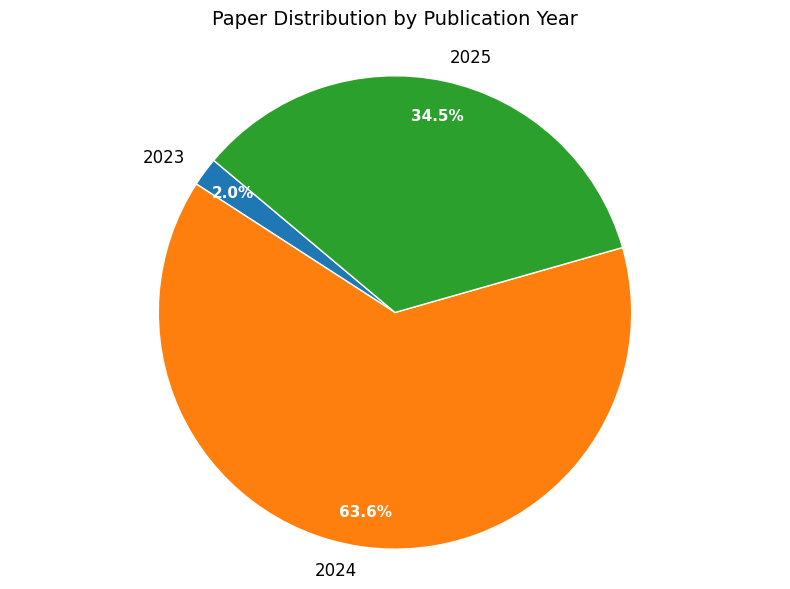

C:\Users\25859\AppData\Local\Temp\ipykernel_22088\1829558277.py:87: UserWarning: Glyph 20854 (\N{CJK UNIFIED IDEOGRAPH-5176}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\25859\AppData\Local\Temp\ipykernel_22088\1829558277.py:87: UserWarning: Glyph 20182 (\N{CJK UNIFIED IDEOGRAPH-4ED6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\25859\AppData\Local\Temp\ipykernel_22088\1829558277.py:93: UserWarning: Glyph 20854 (\N{CJK UNIFIED IDEOGRAPH-5176}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path, bbox_inches='tight', dpi=300, transparent=True)
C:\Users\25859\AppData\Local\Temp\ipykernel_22088\1829558277.py:93: UserWarning: Glyph 20182 (\N{CJK UNIFIED IDEOGRAPH-4ED6}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path, bbox_inches='tight', dpi=300, transparent=True)


图表已保存至: output/charts\category_pie.png


c:\Users\25859\conda3\envs\RAG\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20854 (\N{CJK UNIFIED IDEOGRAPH-5176}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\25859\conda3\envs\RAG\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20182 (\N{CJK UNIFIED IDEOGRAPH-4ED6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


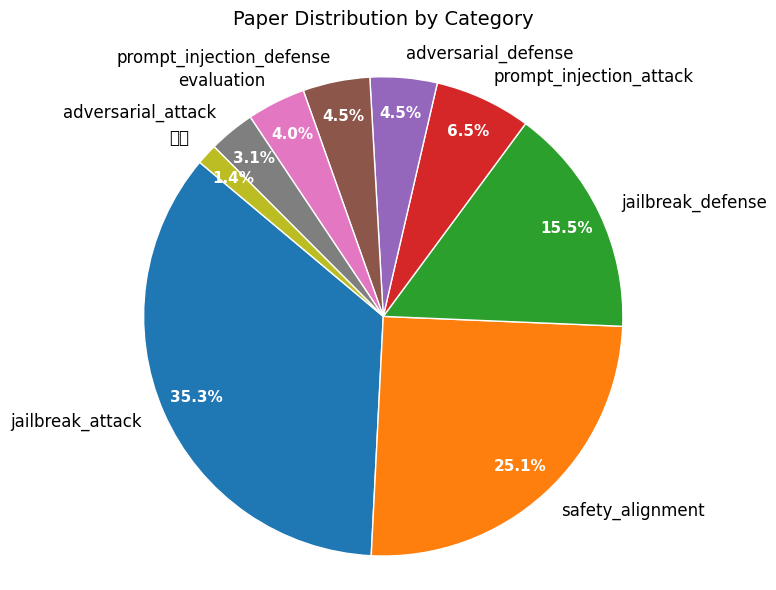

In [42]:
# 数据路径
paper_infos_path = "output/paper_infos7.json"
output_folder = "output/charts"

# 处理论文数据
result = process_paper_data(paper_infos_path, score_threshold=2)

# 绘制年份分布饼状图
plot_pie_chart(
    data=result['year_counts'], 
    labels=result['year_counts'].index, 
    title="Paper Distribution by Publication Year", 
    figsize=(8, 6),
    folder_path=output_folder, 
    filename="publication_year_pie.png"
)

# 绘制类别分布饼状图
plot_pie_chart(
    data=result['category_counts'], 
    labels=result['category_counts'].index, 
    title="Paper Distribution by Category", 
    figsize=(8, 6),
    folder_path=output_folder, 
    filename="category_pie.png"
)

# 绘制桑基图
plot_sankey_chart(
    sankey_data=result['sankey_data'], 
    title="Publication Year → Category Flow", 
    folder_path=output_folder, 
    filename="sankey_diagram.html"
)

绘制桑基图时的测试代码；  
发现需要的格式是{"source":[],"target":[],"value":[]}

In [40]:
# 数据路径
paper_infos_path = "output/paper_infos7.json"
output_folder = "output/charts"

# 处理论文数据
result = process_paper_data(paper_infos_path, score_threshold=2)

sankey_data=result["sankey_data"]
# print(sankey_data)

# 调用函数绘制桑基图
plot_sankey_chart(sankey_data, title="攻击与防御趋势分析", folder_path="./output/charts", filename="attack_defense_trend.html")


'./output/charts\\attack_defense_trend.html'

In [22]:
import pandas as pd

# 示例数据
data = {
    'source': ['2023', '2023', '2023', '2023', '2024', '2024', '2024', '2024', '2024', '2024', 
               '2024', '2024', '2024', '2024', '2024', '2024', '2025', '2025', '2025', '2025', 
               '2025', '2025', '2025', '2025', '2025'],
    'target': ['evaluation', 'jailbreak_attack', 'prompt_injection_attack', 'safety_alignment', 
               'adversarial_attack', 'adversarial_defense', 'backdoor_attack', 'backdoor_defense', 
               'data_extraction_attack', 'editing_attack', 'evaluation', 'jailbreak_attack', 
               'jailbreak_defense', 'prompt_injection_attack', 'prompt_injection_defense', 
               'safety_alignment', 'adversarial_attack', 'adversarial_defense', 'backdoor_attack', 
               'evaluation', 'jailbreak_attack', 'jailbreak_defense', 'prompt_injection_attack', 
               'prompt_injection_defense', 'safety_alignment'],
    'value': [1, 2, 2, 2, 8, 10, 1, 1, 1, 1, 10, 80, 26, 17, 12, 58, 3, 6, 1, 3, 43, 29, 4, 4, 29]
}

print(data)
sankey_data = pd.DataFrame(data)

# 调用函数绘制桑基图
plot_sankey_chart(
    sankey_data, 
    title="AI Security Research Trends (2023-2025)",
    folder_path="output/charts",
    filename="ai_security_sankey.html"
)

{'source': ['2023', '2023', '2023', '2023', '2024', '2024', '2024', '2024', '2024', '2024', '2024', '2024', '2024', '2024', '2024', '2024', '2025', '2025', '2025', '2025', '2025', '2025', '2025', '2025', '2025'], 'target': ['evaluation', 'jailbreak_attack', 'prompt_injection_attack', 'safety_alignment', 'adversarial_attack', 'adversarial_defense', 'backdoor_attack', 'backdoor_defense', 'data_extraction_attack', 'editing_attack', 'evaluation', 'jailbreak_attack', 'jailbreak_defense', 'prompt_injection_attack', 'prompt_injection_defense', 'safety_alignment', 'adversarial_attack', 'adversarial_defense', 'backdoor_attack', 'evaluation', 'jailbreak_attack', 'jailbreak_defense', 'prompt_injection_attack', 'prompt_injection_defense', 'safety_alignment'], 'value': [1, 2, 2, 2, 8, 10, 1, 1, 1, 1, 10, 80, 26, 17, 12, 58, 3, 6, 1, 3, 43, 29, 4, 4, 29]}


'output/charts\\ai_security_sankey.html'